## General Information of Dataset
It generates the battery dataset cycles count with using seperated cycle dataset


In [1]:
import os
import pandas as pd
from collections import defaultdict

def count_files_in_directory(directory_path):
    """Count the number of files in a directory."""
    try:
        count = 0
        for entry in os.listdir(directory_path):
            full_path = os.path.join(directory_path, entry)
            if os.path.isfile(full_path):
                count += 1
        return count
    except FileNotFoundError:
        print(f"Warning: Directory not found: {directory_path}")
        return 0

# Define the base paths
base_path = "../../Discharge_Only_Dataset"
battery_groups = {
    "regular_alt_batteries": [
        "battery00", "battery01", "battery10", "battery11", 
        "battery20", "battery21", "battery22", "battery23", 
        "battery30", "battery31", "battery40", "battery41", 
        "battery50", "battery51", "battery52"
    ],
    "recommissioned_batteries": [
        "battery02", "battery03", "battery12", "battery24", 
        "battery25", "battery32", "battery33", "battery53"
    ],
    "second_life_batteries": [
        "battery13", "battery36", "battery54"
    ]
}

# Create a dictionary to store the counts
file_counts = {}
total_count = 0
group_totals = defaultdict(int)

# Count files for each battery in each group
print("Battery Cycle Count Summary")
print("==========================")

for group, batteries in battery_groups.items():
    print(f"\n{group.upper()}:")
    for battery in batteries:
        directory = os.path.join(base_path, group, battery)
        count = count_files_in_directory(directory)
        file_counts[f"{group}/{battery}"] = count
        group_totals[group] += count
        print(f"  {battery}: {count} cycles")
    
    print(f"Total in {group}: {group_totals[group]} cycles")
    total_count += group_totals[group]

print(f"\nGRAND TOTAL: {total_count} cycles across all batteries")

# Create a sorted list of all batteries by cycle count
sorted_batteries = sorted(file_counts.items(), key=lambda x: x[1], reverse=True)
print("\nBatteries sorted by number of cycles (descending):")
for battery_path, count in sorted_batteries:
    group, battery = battery_path.split('/')
    print(f"  {battery} ({group}): {count} cycles")

# Create a summary DataFrame
summary_data = []
for battery_path, count in sorted_batteries:
    group, battery = battery_path.split('/')
    summary_data.append({
        'Battery': battery,
        'Group': group,
        'Cycles': count
    })

df = pd.DataFrame(summary_data)

# Save summary to CSV
summary_file = "Information/battery_cycles_summary.csv"
df.to_csv(summary_file, index=False)
print(f"\nSummary saved to {summary_file}")

# Print group statistics
print("\nGroup Statistics:")
for group, total in group_totals.items():
    batteries_in_group = len([b for b in file_counts.keys() if b.startswith(group)])
    avg_cycles = total / batteries_in_group if batteries_in_group > 0 else 0
    print(f"  {group}: {total} total cycles, {batteries_in_group} batteries, {avg_cycles:.1f} avg cycles per battery")

Battery Cycle Count Summary

REGULAR_ALT_BATTERIES:
  battery00: 170 cycles
  battery01: 862 cycles
  battery10: 145 cycles
  battery11: 865 cycles
  battery20: 29 cycles
  battery21: 82 cycles
  battery22: 444 cycles
  battery23: 245 cycles
  battery30: 81 cycles
  battery31: 563 cycles
  battery40: 104 cycles
  battery41: 412 cycles
  battery50: 128 cycles
  battery51: 296 cycles
  battery52: 258 cycles
Total in regular_alt_batteries: 4684 cycles

RECOMMISSIONED_BATTERIES:
  battery02: 415 cycles
  battery03: 418 cycles
  battery12: 622 cycles
  battery24: 622 cycles
  battery25: 421 cycles
  battery32: 355 cycles
  battery33: 474 cycles
  battery53: 209 cycles
Total in recommissioned_batteries: 3536 cycles

SECOND_LIFE_BATTERIES:
  battery13: 323 cycles
  battery36: 714 cycles
  battery54: 356 cycles
Total in second_life_batteries: 1393 cycles

GRAND TOTAL: 9613 cycles across all batteries

Batteries sorted by number of cycles (descending):
  battery11 (regular_alt_batteries): 865 c

## Analyze Tempature (Visiulize)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def analyze_battery_temperature(file_path):
    """
    Analyze temperature data from a battery CSV file.
    
    Parameters:
    file_path (str): Path to the battery CSV file
    
    Returns:
    dict: Dictionary containing temperature statistics and the DataFrame
    """
    # Column names based on the paper
    column_names = [
        "start_time", "relative_time", "mode", "voltage_charger", 
        "temperature_battery", "voltage_load", "current_load", 
        "temperature_mosfet", "temperature_resistor", "mission_type"
    ]
    
    # Read the CSV file
    try:
        # First check if the file exists
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            return None
            
        # Try to read with automatic type conversion
        df = pd.read_csv(file_path, names=column_names)
        
        # Check if temperature_battery column exists
        if 'temperature_battery' not in df.columns:
            print(f"Column 'temperature_battery' not found in {file_path}")
            print(f"Available columns: {df.columns.tolist()}")
            return None
        
        # Convert temperature column to numeric, forcing errors to NaN
        df['temperature_battery'] = pd.to_numeric(df['temperature_battery'], errors='coerce')
        df['current_load'] = pd.to_numeric(df['current_load'], errors='coerce')
        df['mode'] = pd.to_numeric(df['mode'], errors='coerce')
        df['relative_time'] = pd.to_numeric(df['relative_time'], errors='coerce')
        
        # Drop NaN values in temperature column
        original_count = len(df)
        df = df.dropna(subset=['temperature_battery'])
        if len(df) < original_count:
            print(f"Dropped {original_count - len(df)} rows with non-numeric temperature values")
        
        print(f"Successfully loaded {file_path}")
        print(f"Number of data points: {len(df)}")
        
        # Print data types and first few rows for debugging
        print("\nData types:")
        print(df.dtypes)
        print("\nFirst few rows:")
        print(df.head())
        
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None
    
    # Calculate temperature statistics
    try:
        temp_stats = {
            'min': df['temperature_battery'].min(),
            'max': df['temperature_battery'].max(),
            'mean': df['temperature_battery'].mean(),
            'median': df['temperature_battery'].median(),
            'std': df['temperature_battery'].std()
        }
        
        # Print temperature statistics
        print("\nTemperature Statistics:")
        print(f"Minimum: {temp_stats['min']:.2f}°C")
        print(f"Maximum: {temp_stats['max']:.2f}°C")
        print(f"Mean: {temp_stats['mean']:.2f}°C")
        print(f"Median: {temp_stats['median']:.2f}°C")
        print(f"Standard Deviation: {temp_stats['std']:.2f}°C")
    except Exception as e:
        print(f"Error calculating statistics: {e}")
        return {'df': df}  # Return just the dataframe if stats fail
    
    # Plot temperature over time
    try:
        plt.figure(figsize=(12, 6))
        
        # Sample the data if it's very large
        if len(df) > 10000:
            sample_rate = len(df) // 10000
            df_plot = df.iloc[::sample_rate]
            print(f"Data sampled at 1/{sample_rate} for plotting")
        else:
            df_plot = df
        
        # Plot the temperature
        plt.plot(df_plot['relative_time']/3600, df_plot['temperature_battery'], 
                '-', color='blue', alpha=0.7)
        
        # Add different colors for different modes if mode column is valid
        if 'mode' in df.columns and not df['mode'].isna().all():
            mode_labels = {-1: 'Discharge', 0: 'Rest', 1: 'Charge'}
            colors = {-1: 'red', 0: 'gray', 1: 'green'}
            
            for mode, color in colors.items():
                mode_data = df_plot[df_plot['mode'] == mode]
                if not mode_data.empty:
                    plt.scatter(
                        mode_data['relative_time']/3600, 
                        mode_data['temperature_battery'],
                        color=color, s=15, alpha=0.5, 
                        label=mode_labels.get(mode, f'Mode {mode}')
                    )
        
        plt.title(f"Battery Temperature Over Time\n{os.path.basename(file_path)}")
        plt.xlabel("Time (hours)")
        plt.ylabel("Temperature (°C)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        
        # Add a second y-axis for current if current_load column is valid
        if 'current_load' in df.columns and not df['current_load'].isna().all():
            ax2 = plt.gca().twinx()
            ax2.plot(df_plot['relative_time']/3600, df_plot['current_load'], 
                    '-', color='orange', alpha=0.4, linewidth=1)
            ax2.set_ylabel('Current (A)', color='orange')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting data: {e}")
    
    # Return statistics and data
    return {
        'stats': temp_stats,
        'df': df
    }


/tmp/ipykernel_26051/2593671884.py:31: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, names=column_names)


Dropped 1 rows with non-numeric temperature values
Successfully loaded ../../Datasets/regular_alt_batteries/battery00.csv
Number of data points: 1101244

Data types:
start_time               object
relative_time           float64
mode                    float64
voltage_charger          object
temperature_battery     float64
voltage_load             object
current_load            float64
temperature_mosfet       object
temperature_resistor     object
mission_type             object
dtype: object

First few rows:
            start_time  relative_time  mode voltage_charger  \
1  2022-07-19 11:10:00          0.000   0.0             0.0   
2  2022-07-19 11:10:00          1.894   0.0           8.341   
3  2022-07-19 11:10:00          2.814   0.0            8.34   
4  2022-07-19 11:10:00          3.734   0.0           8.341   
5  2022-07-19 11:10:00          4.654   0.0           8.341   

   temperature_battery voltage_load  current_load temperature_mosfet  \
1                0.000          

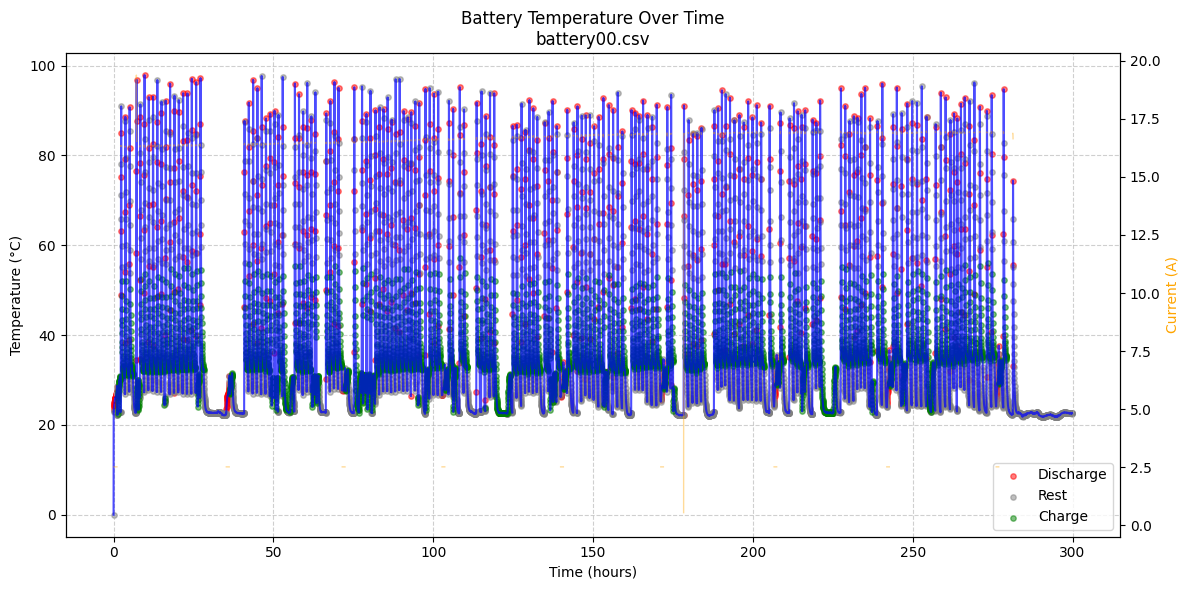

In [3]:
# # Analyze a single battery
result = analyze_battery_temperature("../../Datasets/regular_alt_batteries/battery00.csv")

## Comparing temperature vs current


In [4]:

def plot_temperature_vs_current(df, title=None):
    """
    Create a scatter plot of temperature vs current.
    
    Parameters:
    df (DataFrame): Battery data
    title (str): Optional title for the plot
    """
    try:
        # Ensure columns are numeric
        df = df.copy()
        df['temperature_battery'] = pd.to_numeric(df['temperature_battery'], errors='coerce')
        df['current_load'] = pd.to_numeric(df['current_load'], errors='coerce')
        df['mode'] = pd.to_numeric(df['mode'], errors='coerce')
        df['relative_time'] = pd.to_numeric(df['relative_time'], errors='coerce')
        
        # Drop NaNs
        df = df.dropna(subset=['temperature_battery', 'current_load'])
        
        # Filter to discharge mode if possible
        if 'mode' in df.columns and not df['mode'].isna().all():
            discharge_df = df[df['mode'] == -1]
            if discharge_df.empty:
                print("No discharge data found, using all data")
                discharge_df = df
        else:
            print("Mode column not available, using all data")
            discharge_df = df
        
        # Sample if needed
        if len(discharge_df) > 5000:
            discharge_df = discharge_df.sample(n=5000)
        
        plt.figure(figsize=(10, 8))
        
        # Create scatter plot
        if 'relative_time' in discharge_df.columns and not discharge_df['relative_time'].isna().all():
            scatter = plt.scatter(
                discharge_df['current_load'], 
                discharge_df['temperature_battery'],
                c=discharge_df['relative_time']/3600,  # Color by time
                cmap='viridis',
                alpha=0.7,
                s=20
            )
            
            # Add colorbar
            cbar = plt.colorbar(scatter)
            cbar.set_label('Time (hours)')
        else:
            plt.scatter(
                discharge_df['current_load'], 
                discharge_df['temperature_battery'],
                alpha=0.7,
                s=20
            )
        
        # Add regression line
        if len(discharge_df) > 10:
            z = np.polyfit(discharge_df['current_load'], discharge_df['temperature_battery'], 1)
            p = np.poly1d(z)
            x_range = np.linspace(discharge_df['current_load'].min(), discharge_df['current_load'].max(), 100)
            plt.plot(x_range, p(x_range), "r--", alpha=0.8)
            
            # Add equation
            equation = f"Temp = {z[0]:.2f} × Current + {z[1]:.2f}"
            plt.annotate(equation, xy=(0.05, 0.95), xycoords='axes fraction', 
                        fontsize=10, backgroundcolor='white')
        
        plt.title(title or "Temperature vs. Current (During Discharge)")
        plt.xlabel("Current (A)")
        plt.ylabel("Temperature (°C)")
        plt.grid(True, alpha=0.3)
       
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting temperature vs current: {e}")

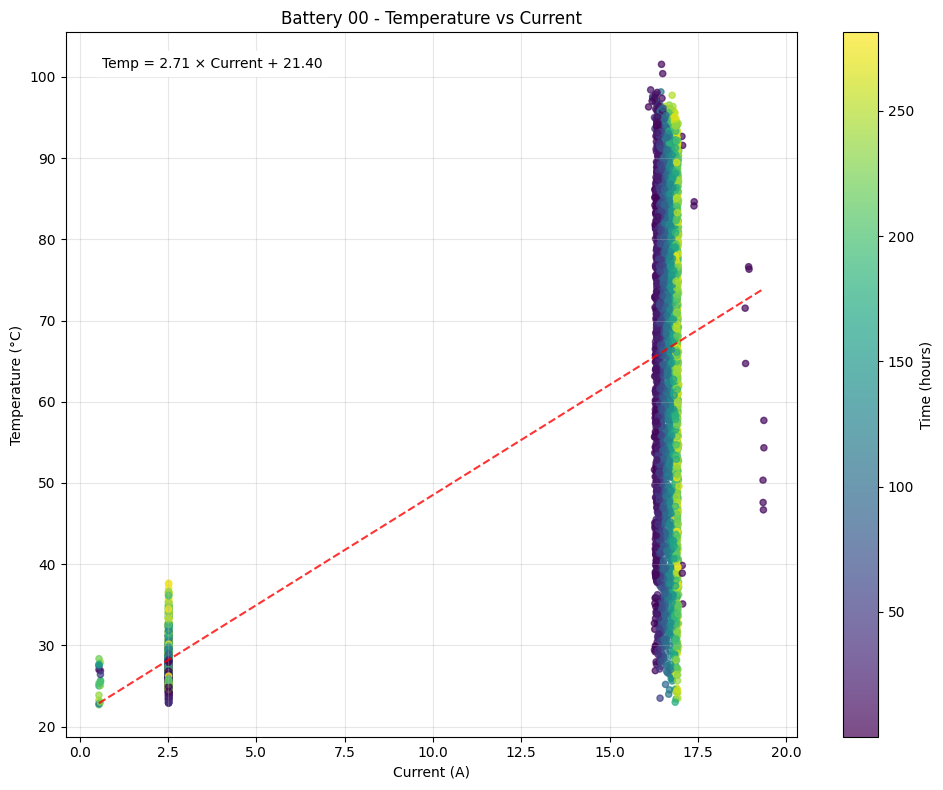

In [5]:
# # If successful, we can use the DataFrame for further analysis
if result:
    df = result['df']
    
    # Plot temperature vs current
    plot_temperature_vs_current(df, "Battery 00 - Temperature vs Current")

## Comparing the Tempatures between batteries

In [6]:

def compare_battery_temperatures(file_paths, labels=None):
    """
    Compare temperature profiles between multiple batteries.
    
    Parameters:
    file_paths (list): List of paths to battery CSV files
    labels (list): Optional list of labels for the batteries
    """
    try:
        plt.figure(figsize=(14, 8))
        
        # Column names
        column_names = [
            "start_time", "relative_time", "mode", "voltage_charger", 
            "temperature_battery", "voltage_load", "current_load", 
            "temperature_mosfet", "temperature_resistor", "mission_type"
        ]
        
        # Process each file
        summary_data = []
        
        for i, file_path in enumerate(file_paths):
            try:
                # Use the file name as label if not provided
                label = labels[i] if labels and i < len(labels) else os.path.basename(file_path)
                
                # Read data
                df = pd.read_csv(file_path, names=column_names, low_memory=False)
                
                # Convert columns to numeric
                df['temperature_battery'] = pd.to_numeric(df['temperature_battery'], errors='coerce')
                df['relative_time'] = pd.to_numeric(df['relative_time'], errors='coerce')
                
                # Drop NaNs
                df = df.dropna(subset=['temperature_battery', 'relative_time'])
                
                # Sample for plotting and create explicit copy
                if len(df) > 5000:
                    sample_rate = len(df) // 5000
                    df_plot = df.iloc[::sample_rate].copy()
                else:
                    df_plot = df.copy()
                
                # Calculate smoothed temperature for better visualization
                df_plot['temp_smooth'] = df_plot['temperature_battery'].rolling(window=10, min_periods=1).mean()
                
                # Plot the temperature
                plt.plot(df_plot['relative_time']/3600, df_plot['temp_smooth'], 
                        label=label, alpha=0.7)
                
                # Collect statistics
                summary_data.append({
                    'Battery': label,
                    'Max Temp': df['temperature_battery'].max(),
                    'Avg Temp': df['temperature_battery'].mean(),
                    'Time to Max (h)': df.loc[df['temperature_battery'].idxmax(), 'relative_time']/3600,
                    'Data Points': len(df)
                })
                
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        
        plt.title("Battery Temperature Comparison")
        plt.xlabel("Time (hours)")
        plt.ylabel("Temperature (°C)")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Show summary table
        if summary_data:
            summary_df = pd.DataFrame(summary_data)
            print("\nTemperature Summary:")
            return summary_df.sort_values(by='Max Temp', ascending=False)
        
        return None
    except Exception as e:
        print(f"Error comparing battery temperatures: {e}")
        return None

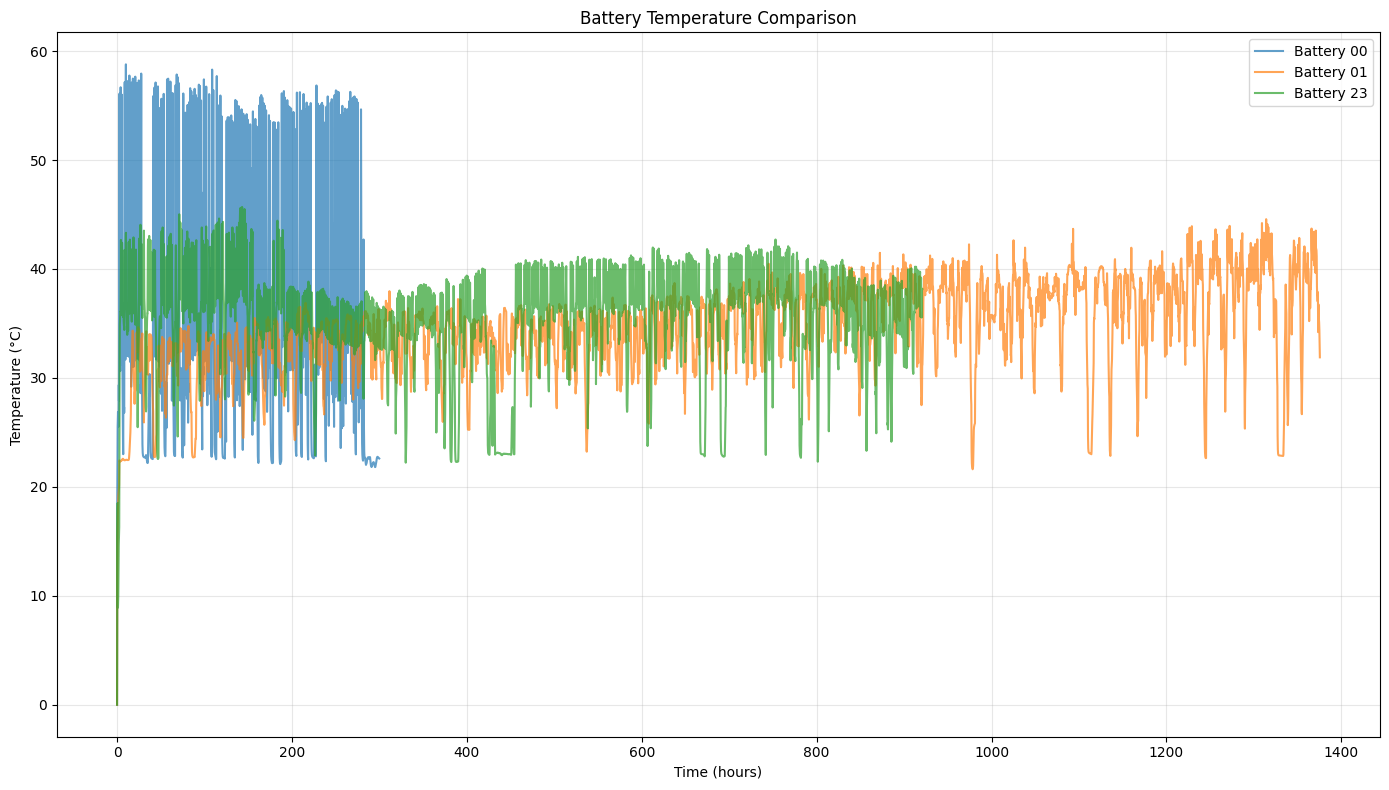


Temperature Summary:


In [7]:
# # Compare multiple batteries
batteries = [
    "../../Datasets/regular_alt_batteries/battery00.csv",
    "../../Datasets/regular_alt_batteries/battery01.csv",
    "../../Datasets/recommissioned_batteries/battery24.csv"
]

summary = compare_battery_temperatures(batteries, ["Battery 00", "Battery 01", "Battery 23"])

## Current Profile Metrics Function

In [10]:
def calculate_current_profile_metrics(discharge_data):
    """
    Calculate current profile metrics from discharge data.
    
    Args:
        discharge_data (DataFrame): DataFrame containing discharge data (filtered for mode = -1)
    
    Returns:
        dict: Dictionary containing current profile metrics
    """
    # Handle NaN values in current_load
    valid_current = discharge_data['current_load'].dropna()
    
    if len(valid_current) == 0:
        return {
            'mean_current_A': 0,
            'max_current_A': 0,
            'current_variability': 0,
            'is_constant_current': True
        }
    
    # Calculate current profile metrics
    mean_current = valid_current.mean()
    max_current = valid_current.max()
    current_std = valid_current.std()  # Measure of variability
    
    # Check if it's constant or variable current based on standard deviation
    is_constant_current = current_std < 1.0  # Threshold can be adjusted
    
    # Create metrics dictionary
    current_metrics = {
        'mean_current_A': mean_current,
        'max_current_A': max_current,
        'current_variability': current_std,
        'is_constant_current': is_constant_current
    }
    
    return current_metrics

## Energy Metrics Function


In [11]:
def calculate_energy_metrics(cycle_data):
    """
    Calculate energy-related metrics from the cycle data.
    
    Args:
        cycle_data (DataFrame): DataFrame containing full cycle data
    
    Returns:
        dict: Dictionary containing energy metrics
    """
    # Separate discharge and charge data
    discharge_data = cycle_data[cycle_data['mode'] == -1]
    charge_data = cycle_data[cycle_data['mode'] == 1]
    
    if len(discharge_data) == 0:
        return {'total_discharge_energy_Wh': 0, 'avg_power_W': 0, 'energy_efficiency_pct': 0}
    
    # Calculate energy metrics for discharge
    # Energy (Wh) = ∫ P dt = ∫ V × I dt
    discharge_energy = 0
    for i in range(1, len(discharge_data)):
        time_delta = (discharge_data['time'].iloc[i] - 
                      discharge_data['time'].iloc[i-1]) / 3600  # Convert to hours
        
        voltage = discharge_data['voltage_load'].iloc[i]
        current = discharge_data['current_load'].iloc[i]
        
        # Skip if either voltage or current is NaN
        if pd.isna(voltage) or pd.isna(current):
            continue
            
        power = voltage * current  # in Watts
        energy_increment = power * time_delta  # in Watt-hours
        discharge_energy += energy_increment
    
    # Calculate average power during discharge
    avg_power = 0
    if discharge_data['time'].max() > discharge_data['time'].min():
        total_discharge_time_h = (discharge_data['time'].max() - 
                                 discharge_data['time'].min()) / 3600
        avg_power = discharge_energy / total_discharge_time_h if total_discharge_time_h > 0 else 0
    
    # Calculate energy efficiency if charge data exists
    energy_efficiency = 0
    if len(charge_data) > 0:
        # Calculate charge energy
        charge_energy = 0
        for i in range(1, len(charge_data)):
            time_delta = (charge_data['time'].iloc[i] - 
                          charge_data['time'].iloc[i-1]) / 3600  # Convert to hours
            voltage = charge_data['voltage_charger'].iloc[i]
            
            # Assuming constant charge current of 3A as mentioned in the paper
            current = 3.0  
            
            # Skip if voltage is NaN
            if pd.isna(voltage):
                continue
                
            power = voltage * current  # in Watts
            energy_increment = power * time_delta  # in Watt-hours
            charge_energy += energy_increment
        
        # Calculate efficiency (discharge energy / charge energy)
        energy_efficiency = (discharge_energy / charge_energy * 100) if charge_energy > 0 else 0
    
    # Create metrics dictionary
    energy_metrics = {
        'total_discharge_energy_Wh': discharge_energy,
        'avg_power_W': avg_power,
        'energy_efficiency_pct': energy_efficiency
    }
    
    return energy_metrics

## Tempature Metrics Function

In [12]:
def calculate_temperature_metrics(discharge_data):
    """
    Calculate temperature-related metrics from discharge data.
    
    Args:
        discharge_data (DataFrame): DataFrame containing discharge data (filtered for mode = -1)
    
    Returns:
        dict: Dictionary containing temperature metrics
    """
    # Boş değerlere karşı koruma
    if 'temperature_battery' not in discharge_data.columns:
        return {
            'mean_temperature_C': 0,
            'median_temperature_C': 0,
            'max_temperature_C': 0,
            'initial_temperature_C': 0,
            'final_temperature_C': 0,
            'temperature_rise_rate_C_per_min': 0
        }
        
    # NaN olmayan sıcaklık değerlerini al
    valid_temp = discharge_data['temperature_battery'].dropna()
    
    if len(valid_temp) == 0:
        return {
            'mean_temperature_C': 0,
            'median_temperature_C': 0,
            'max_temperature_C': 0,
            'initial_temperature_C': 0,
            'final_temperature_C': 0,
            'temperature_rise_rate_C_per_min': 0
        }
    
    # Temel sıcaklık istatistikleri
    mean_temp = valid_temp.mean()
    median_temp = valid_temp.median()
    max_temp = valid_temp.max()
    
    # İlk ve son sıcaklıkları güvenli bir şekilde al
    initial_temp = valid_temp.iloc[0] if len(valid_temp) > 0 else 0
    final_temp = valid_temp.iloc[-1] if len(valid_temp) > 0 else 0
    
    # Sıcaklık artış oranını hesapla (C/dakika)
    if 'time' in discharge_data.columns and len(discharge_data) > 1:
        total_time_minutes = (discharge_data['time'].max() - 
                             discharge_data['time'].min()) / 60
        temp_rise_rate = (final_temp - initial_temp) / total_time_minutes if total_time_minutes > 0 else 0
    else:
        temp_rise_rate = 0
    
    # Metrik sözlüğünü oluştur
    temp_metrics = {
        'mean_temperature_C': mean_temp,
        'median_temperature_C': median_temp,
        'max_temperature_C': max_temp,
        'initial_temperature_C': initial_temp,
        'final_temperature_C': final_temp,
        'temperature_rise_rate_C_per_min': temp_rise_rate
    }
    
    return temp_metrics

## Performanace Metrics Function

In [13]:
def calculate_performance_metrics(discharge_data):
    """
    Calculate performance-related metrics from discharge data.
    
    Args:
        discharge_data (DataFrame): DataFrame containing discharge data (filtered for mode = -1)
    
    Returns:
        dict: Dictionary containing performance metrics
    """
    # Calculate discharge time in minutes
    discharge_time_min = (discharge_data['time'].max() - 
                         discharge_data['time'].min()) / 60
    
    # Calculate specific energy (Wh/kg)
    # Since we have 2 Samsung INR18650-25R cells in series, we can estimate the weight
    # Weight of a single Samsung INR18650-25R is about 45g, so 2S pack ≈ 90g = 0.09kg
    pack_weight_kg = 0.09
    
    # Calculate total energy discharged
    total_energy_wh = 0
    for i in range(1, len(discharge_data)):
        time_delta = (discharge_data['time'].iloc[i] - 
                      discharge_data['time'].iloc[i-1]) / 3600  # Convert to hours
        
        voltage = discharge_data['voltage_load'].iloc[i]
        current = discharge_data['current_load'].iloc[i]
        
        # Skip if data is NaN
        if pd.isna(voltage) or pd.isna(current):
            continue
            
        power = voltage * current  # in Watts
        energy_increment = power * time_delta  # in Watt-hours
        total_energy_wh += energy_increment
    
    # Calculate specific energy
    specific_energy = total_energy_wh / pack_weight_kg if pack_weight_kg > 0 else 0
    
    # Estimate internal resistance
    # Using voltage drop method at the beginning of discharge
    # ΔV/ΔI where ΔV is the voltage drop when current is applied
    
    # Get the first few points of discharge data (excluding NaN values)
    valid_discharge = discharge_data.dropna(subset=['voltage_load', 'current_load'])
    
    # Try to estimate initial voltage drop
    internal_resistance = 0
    if len(valid_discharge) >= 2:
        # Initial voltage (ideally from rest period before discharge)
        # This is approximate; a more accurate method would use the voltage right before discharge
        initial_voltage = valid_discharge['voltage_load'].iloc[0]
        
        # Voltage after current has been applied
        loaded_voltage = valid_discharge['voltage_load'].iloc[-1]
        
        # Current applied
        current = valid_discharge['current_load'].mean()
        
        # Calculate internal resistance (Ohms)
        voltage_drop = initial_voltage - loaded_voltage
        internal_resistance = voltage_drop / current if current > 0 else 0
    
    # Create metrics dictionary
    performance_metrics = {
        'discharge_time_min': discharge_time_min,
        'specific_energy_Wh_per_kg': specific_energy,
        'internal_resistance_ohm': internal_resistance
    }
    
    return performance_metrics

## Regular Discharge Processing Function


In [14]:
def process_discharge(cycle_file, summary_df):
    """
    Process a regular discharge cycle and extract relevant features.
    
    Args:
        cycle_file (str): Path to the cycle CSV file
        summary_df (DataFrame): DataFrame to append the extracted features to
    
    Returns:
        DataFrame: Updated summary DataFrame with the new row added
    """
    # Read the cycle data
    cycle_data = pd.read_csv(cycle_file)
    
    # Get cycle ID from filename
    cycle_id = os.path.basename(cycle_file).replace('.csv', '')
    
    # Filter only discharge data (mode = -1)
    discharge_data = cycle_data[cycle_data['mode'] == -1]
    
    if len(discharge_data) == 0:
        print(f"No discharge data found in {cycle_file}")
        return summary_df
    
    # Create a summary row with basic information
    summary_row = {
        'cycle_id': cycle_id,
        'start_time': cycle_data['start_time'].iloc[0] if 'start_time' in cycle_data.columns else 'Unknown',
    }
    
    try:
        # Calculate and add current profile metrics
        current_metrics = calculate_current_profile_metrics(discharge_data)
        summary_row.update(current_metrics)
    except Exception as e:
        print(f"Error calculating current metrics for {cycle_id}: {e}")
    
    try:
        # Calculate and add energy metrics
        energy_metrics = calculate_energy_metrics(cycle_data)
        summary_row.update(energy_metrics)
    except Exception as e:
        print(f"Error calculating energy metrics for {cycle_id}: {e}")
    
    try:
        # Calculate and add temperature metrics
        temp_metrics = calculate_temperature_metrics(discharge_data)
        summary_row.update(temp_metrics)
    except Exception as e:
        print(f"Error calculating temperature metrics for {cycle_id}: {e}")
    
    try:
        # Calculate and add performance metrics
        perf_metrics = calculate_performance_metrics(discharge_data)
        summary_row.update(perf_metrics)
    except Exception as e:
        print(f"Error calculating performance metrics for {cycle_id}: {e}")
    
    # Return the updated DataFrame with the new row appended
    return pd.concat([summary_df, pd.DataFrame([summary_row])], ignore_index=True)

## Total Capacity Calculation Function

In [15]:
def calculate_total_capacity(discharge_data):
    """
    Calculate the total discharged capacity in Amp-hours.
    
    Args:
        discharge_data (DataFrame): DataFrame containing discharge data
    
    Returns:
        float: Total discharged capacity in Amp-hours
    """
    total_capacity = 0.0
    
    # Iterate through discharge data points
    for i in range(1, len(discharge_data)):
        # Calculate time step in hours
        time_step = (discharge_data['time'].iloc[i] - 
                    discharge_data['time'].iloc[i-1]) / 3600
        
        # Get current value
        current = discharge_data['current_load'].iloc[i]
        
        # Handle NaN or invalid current values
        if pd.isna(current) or current <= 0:
            continue
        
        # Capacity is current × time
        capacity_increment = current * time_step
        total_capacity += capacity_increment
    
    return total_capacity

## Voltage Profile Metrics Function

In [16]:
def calculate_voltage_profile_metrics(discharge_data):
    """
    Calculate voltage profile metrics from discharge data.
    
    Args:
        discharge_data (DataFrame): DataFrame containing discharge data
    
    Returns:
        dict: Dictionary containing voltage profile metrics
    """
    # Handle NaN values in voltage_load
    valid_voltage = discharge_data['voltage_load'].dropna()
    
    if len(valid_voltage) == 0:
        return {
            'initial_voltage_V': 0,
            'final_voltage_V': 0,
            'min_voltage_V': 0,
            'voltage_drop_rate_V_per_min': 0,
            'linear_portion_slope_V_per_min': 0
        }
    
    # Get voltage values from indices where voltage is not NaN
    voltage_series = discharge_data['voltage_load']
    valid_indices = voltage_series[~pd.isna(voltage_series)].index
    
    if len(valid_indices) > 0:
        initial_voltage = voltage_series.iloc[valid_indices[0]]
        final_voltage = voltage_series.iloc[valid_indices[-1]]
    else:
        initial_voltage = 0
        final_voltage = 0
        
    min_voltage = valid_voltage.min()
    
    # Calculate voltage drop rate (V/minute) over the entire discharge
    discharge_duration_min = (discharge_data['time'].max() - 
                             discharge_data['time'].min()) / 60
    
    voltage_drop_rate = (initial_voltage - final_voltage) / discharge_duration_min if discharge_duration_min > 0 else 0
    
    # Find the linear portion of the discharge curve
    # For simplicity, we'll use the middle 60% of the discharge data
    # But only use rows where voltage is not NaN
    valid_discharge = discharge_data[~pd.isna(discharge_data['voltage_load'])]
    
    if len(valid_discharge) > 10:
        middle_start_idx = int(len(valid_discharge) * 0.2)
        middle_end_idx = int(len(valid_discharge) * 0.8)
        middle_portion = valid_discharge.iloc[middle_start_idx:middle_end_idx]
        
        # Calculate linear slope in the middle portion
        if len(middle_portion) > 10:  # Ensure we have enough points
            # Use linear regression to find the slope
            time_values = middle_portion['time'].values
            voltage_values = middle_portion['voltage_load'].values
            
            # Normalize time values to make computation more stable
            normalized_time = (time_values - time_values[0]) / 60  # in minutes
            
            # Calculate slope using least squares
            n = len(normalized_time)
            sum_x = sum(normalized_time)
            sum_y = sum(voltage_values)
            sum_xy = sum(normalized_time * voltage_values)
            sum_xx = sum(normalized_time ** 2)
            
            # Linear regression formula: slope = (n*sum_xy - sum_x*sum_y) / (n*sum_xx - sum_x^2)
            denominator = n * sum_xx - sum_x ** 2
            linear_slope = (n * sum_xy - sum_x * sum_y) / denominator if denominator != 0 else 0
        else:
            linear_slope = 0
    else:
        linear_slope = 0
    
    # Create metrics dictionary
    voltage_metrics = {
        'initial_voltage_V': initial_voltage,
        'final_voltage_V': final_voltage,
        'min_voltage_V': min_voltage,
        'voltage_drop_rate_V_per_min': voltage_drop_rate,
        'linear_portion_slope_V_per_min': linear_slope
    }
    
    return voltage_metrics

## Reference Discharge Processing Function

In [17]:
def process_reference_discharge(cycle_file, summary_df, initial_capacity=None):
    """
    Process a reference discharge cycle and extract relevant features.
    
    Args:
        cycle_file (str): Path to the cycle CSV file
        summary_df (DataFrame): DataFrame to append the extracted features to
        initial_capacity (float, optional): Initial capacity for SOH calculation.
                                           If None, this cycle is treated as the initial.
    
    Returns:
        tuple: (Updated summary DataFrame, Current cycle capacity)
    """
    # Read the cycle data
    cycle_data = pd.read_csv(cycle_file)
    
    # Get cycle ID from filename
    cycle_id = os.path.basename(cycle_file).replace('.csv', '')
    
    # Filter only discharge data (mode = -1)
    discharge_data = cycle_data[cycle_data['mode'] == -1]
    
    if len(discharge_data) == 0:
        print(f"No discharge data found in {cycle_file}")
        return summary_df, 0
    
    # Calculate total discharged capacity (Amp-hours)
    try:
        total_capacity = calculate_total_capacity(discharge_data)
    except Exception as e:
        print(f"Error calculating capacity for {cycle_id}: {e}")
        total_capacity = 0
    
    # Calculate SOH if initial capacity is provided
    soh_percent = 100.0
    if initial_capacity is not None and initial_capacity > 0:
        soh_percent = (total_capacity / initial_capacity) * 100
    
    # Create a summary row with basic information
    summary_row = {
        'cycle_id': cycle_id,
        'start_time': cycle_data['start_time'].iloc[0] if 'start_time' in cycle_data.columns else 'Unknown',
        'total_capacity_Ah': total_capacity,
        'SOH_percent': soh_percent
    }
    
    try:
        # Calculate and add voltage profile metrics
        voltage_metrics = calculate_voltage_profile_metrics(discharge_data)
        summary_row.update(voltage_metrics)
    except Exception as e:
        print(f"Error calculating voltage metrics for {cycle_id}: {e}")
    
    try:
        # Calculate and add temperature metrics
        temp_metrics = calculate_temperature_metrics(discharge_data)
        summary_row.update(temp_metrics)
    except Exception as e:
        print(f"Error calculating temperature metrics for {cycle_id}: {e}")
    
    # Calculate discharge time
    try:
        discharge_time_min = (discharge_data['time'].max() - 
                             discharge_data['time'].min()) / 60
        summary_row['discharge_time_min'] = discharge_time_min
    except Exception as e:
        print(f"Error calculating discharge time for {cycle_id}: {e}")
        summary_row['discharge_time_min'] = 0
    
    # Return the updated DataFrame and the calculated capacity
    return pd.concat([summary_df, pd.DataFrame([summary_row])], ignore_index=True), total_capacity

## Sort the Cycles in summary file

In [18]:
# CSV dosyalarını kaydetmeden önce cycle_id'ye göre sayısal olarak sırala
def natural_sort_key(row):
    import re
    # 'cycle_id' değerindeki sayıları çıkarıp sayısal değer olarak karşılaştır
    s = row['cycle_id']
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'(\d+)', s)]

## Scan the battery.csv files for summary cycles


In [19]:
import os
import pandas as pd
import glob
import numpy as np

def scan_battery_directory(battery_dir):
    """
    Scans the battery directory for cycle files and organizes them into reference and regular discharge files.
    
    Args:
        battery_dir (str): Path to the battery directory (e.g., 'battery00')
    
    Returns:
        None
    """
    # Create summary directory if it doesn't exist
    summary_dir = os.path.join(battery_dir, 'summary')
    if not os.path.exists(summary_dir):
        os.makedirs(summary_dir)
    
    # Initialize dataframes for reference and regular discharge cycles
    reference_discharge_df = pd.DataFrame()
    discharge_df = pd.DataFrame()
    
    # Get all CSV files in the battery directory
    csv_files = glob.glob(os.path.join(battery_dir, '*.csv'))
    
    # Sort files to ensure chronological order
    csv_files.sort()
    
    # Variable to store initial capacity
    initial_capacity = None
    
    # Process each cycle file
    for cycle_file in csv_files:
        filename = os.path.basename(cycle_file)
        
        # Try to determine if it's a reference cycle based on the filename
        is_reference = '_reference' in filename
        
        try:
            # Read the first few rows to check
            sample_df = pd.read_csv(cycle_file, nrows=10)
            
            # If we can't determine from filename, check mission_type column
            # According to the paper, reference cycles use mission_type=0
            if not is_reference and 'mission_type' in sample_df.columns:
                # Check if any rows have mission_type=0 (reference discharge)
                try:
                    if any(sample_df['mission_type'] == 0):
                        is_reference = True
                except:
                    # If mission_type column exists but can't be used for comparison
                    # (e.g., contains NaN), just skip this check
                    pass
        except Exception as e:
            print(f"Error checking file {filename}: {e}")
            continue
            
        try:
            if is_reference:
                print(f"Processing reference discharge file: {filename}")
                reference_discharge_df, capacity = process_reference_discharge(cycle_file, reference_discharge_df, initial_capacity)
                
                # If this is the first reference cycle, set initial capacity
                if initial_capacity is None:
                    initial_capacity = capacity
                    # Update SOH for the first cycle manually
                    if len(reference_discharge_df) > 0:
                        reference_discharge_df.loc[0, 'SOH_percent'] = 100.0
            else:
                print(f"Processing regular discharge file: {filename}")
                discharge_df = process_discharge(cycle_file, discharge_df)
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
    

    # Dataframe'leri cycle_id'ye göre sırala
    reference_discharge_df = reference_discharge_df.sort_values(
        by='cycle_id', 
        key=lambda x: x.map(lambda s: natural_sort_key({'cycle_id': s}))
    )

    discharge_df = discharge_df.sort_values(
        by='cycle_id', 
        key=lambda x: x.map(lambda s: natural_sort_key({'cycle_id': s}))
    )


    # Save the summary files
    reference_output_path = os.path.join(summary_dir, 'reference_discharge.csv')
    discharge_output_path = os.path.join(summary_dir, 'discharge.csv')
    
    reference_discharge_df.to_csv(reference_output_path, index=False)
    discharge_df.to_csv(discharge_output_path, index=False)
    
    print(f"Summary files created in {summary_dir}")
    print(f"Reference discharge summary: {len(reference_discharge_df)} cycles")
    print(f"Regular discharge summary: {len(discharge_df)} cycles")

In [ ]:
# TODO: Implement process_reference_discharge function
# This function will extract features from reference discharge cycles:
# - Total discharged capacity
# - SOH calculation
# - Voltage profile metrics
# - Temperature metrics
# - Discharge time

# TODO: Implement process_discharge function
# This function will extract features from regular discharge cycles:
# - Current profile metrics
# - Energy metrics
# - Temperature metrics
# - Performance metrics

In [20]:
cycle_directory = [
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery00",
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery01",
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery10",
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery11",
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery20",
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery21",
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery22",
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery23",
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery30",
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery31",
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery40",
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery41",
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery50",
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery51",
    "../../Discharge_Only_Dataset/regular_alt_batteries/battery52",
    "../../Discharge_Only_Dataset/recommissioned_batteries/battery02",
    "../../Discharge_Only_Dataset/recommissioned_batteries/battery03",
    "../../Discharge_Only_Dataset/recommissioned_batteries/battery12",
    "../../Discharge_Only_Dataset/recommissioned_batteries/battery24",
    "../../Discharge_Only_Dataset/recommissioned_batteries/battery25",
    "../../Discharge_Only_Dataset/recommissioned_batteries/battery32",
    "../../Discharge_Only_Dataset/recommissioned_batteries/battery33",
    "../../Discharge_Only_Dataset/recommissioned_batteries/battery53",
    "../../Discharge_Only_Dataset/second_life_batteries/battery13",
    "../../Discharge_Only_Dataset/second_life_batteries/battery36",
    "../../Discharge_Only_Dataset/second_life_batteries/battery54"
]

In [21]:
# Iterate through all battery directories and scan each one
for directory in cycle_directory:
	print(f"\nProcessing directory: {directory}")
	try:
		scan_battery_directory(directory)
	except Exception as e:
		print(f"Error processing {directory}: {e}")


Processing directory: ../../Discharge_Only_Dataset/regular_alt_batteries/battery00
Processing regular discharge file: discharge10.csv
Processing regular discharge file: discharge100.csv
Processing regular discharge file: discharge101.csv
Processing regular discharge file: discharge102.csv
Processing regular discharge file: discharge103.csv
Processing regular discharge file: discharge104.csv
Processing reference discharge file: discharge105_reference.csv
Processing regular discharge file: discharge106.csv
Processing regular discharge file: discharge107.csv
Processing regular discharge file: discharge108.csv
Processing regular discharge file: discharge109.csv
Processing regular discharge file: discharge11.csv
Processing regular discharge file: discharge110.csv
Processing regular discharge file: discharge111.csv
Processing regular discharge file: discharge112.csv
Processing regular discharge file: discharge113.csv
Processing regular discharge file: discharge114.csv
Processing regular dis